In [98]:
%matplotlib inline
%load_ext ipython_unittest
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers

The ipython_unittest extension is already loaded. To reload it, use:
  %reload_ext ipython_unittest


In [99]:
data = pd.read_csv('data/market_data.csv').drop(columns=['Unnamed: 0', 'Time'])
num_of_ts = data.shape[1]
data_numpy = data.values.T
np.random.shuffle(data_numpy)

In [102]:
n_steps_for_train = 60
n_samples = num_of_ts/2

x_train = data_numpy[:num_of_ts/2, :n_steps_for_train].reshape(n_samples, n_steps_for_train, 1) * 2000
y_train = data_numpy[:num_of_ts/2, n_steps_for_train:] * 2000

x_test = data_numpy[num_of_ts/2:, :n_steps_for_train].reshape(n_samples, n_steps_for_train, 1) * 2000
y_test = data_numpy[num_of_ts/2:, n_steps_for_train:] * 2000


In [103]:
input_dim = n_steps_for_train
model = Sequential()
model.add(Convolution1D(filters=1, kernel_size=4, input_shape=(60 ,1)))
model.add(Flatten())
model.add(Dense(units=32, kernel_initializer='normal'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=60, actiivation='relu'))
# model.add(Dense(units=40, activation='relu'))
model.add(Dense(units=120-input_dim, activation='linear'))


sgd = optimizers.SGD(lr=0.1)
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['mae'])

history = model.fit(x_train, y_train, epochs=30, batch_size=4, validation_split=.3, verbose=2)

In [107]:
history.history['mean_absolute_error']

[0.30721188150695744,
 0.16818055955971534,
 0.1579938740320993,
 0.1502874677370607,
 0.14241689387673956,
 0.13425954884201233,
 0.12645279224251418,
 0.11914170206319995,
 0.1128322872903438,
 0.10751718840444736,
 0.10325746129664724,
 0.09970105099745137,
 0.09688095158994608,
 0.09446627373170524,
 0.09257468106859994,
 0.09087255161448968,
 0.0894611828154963,
 0.08816480544804035,
 0.08701997197199941,
 0.08606938054648841,
 0.08513474862805898,
 0.08429125529609671,
 0.08344838275266037,
 0.08276298526136334,
 0.08210320398910408,
 0.08146659229847697,
 0.08091100999588069,
 0.08041253856489851,
 0.07992326229195658,
 0.07943130756091743]

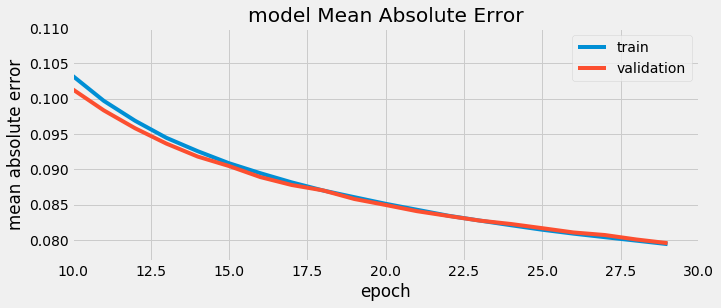

In [114]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 4))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.xlim(10,30)
plt.ylim(.077, .11)
plt.title('model Mean Absolute Error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show();

In [ ]:
y_pred_train = model.predict(x_train)

random_indexes = range(data.shape[1]/2)
random.shuffle(random_indexes)

for i in random_indexes[:5]:
    plt.figure()
    plt.plot(range(60), x_train[i], marker='o', markersize=3, label='input')
    plt.plot(range(60, 120), y_train[i], label='true')
    plt.plot(range(60, 120), y_pred_train[i], c='m', label='prediction')
    plt.title('train')
    plt.legend()

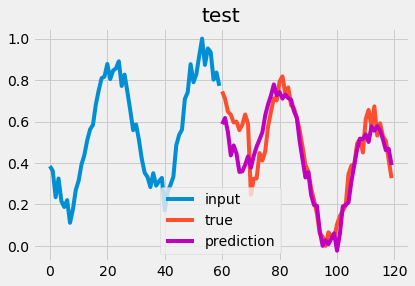

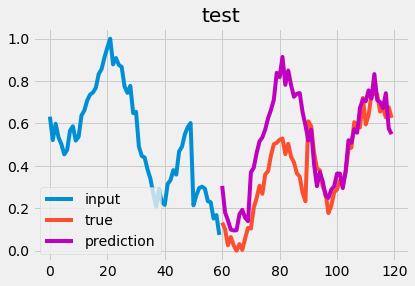

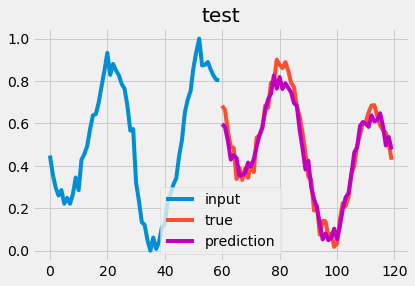

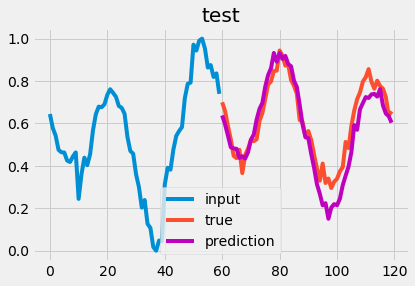

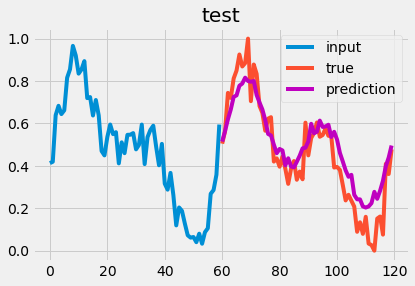

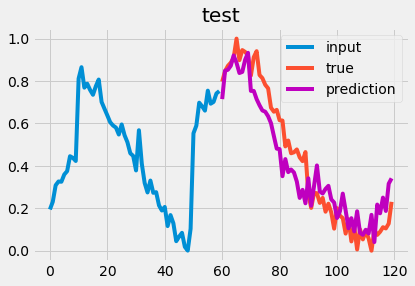

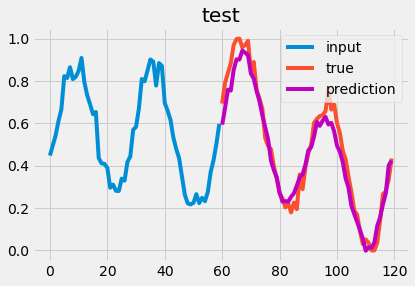

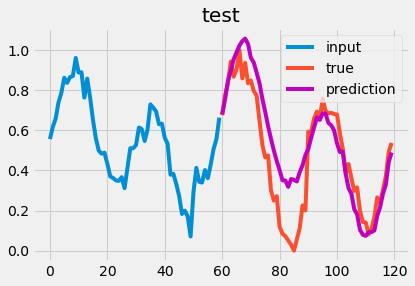

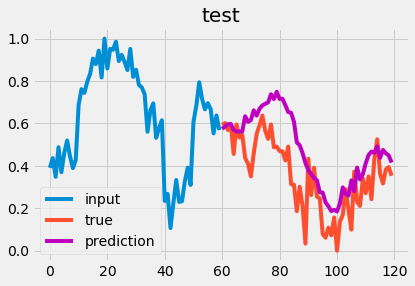

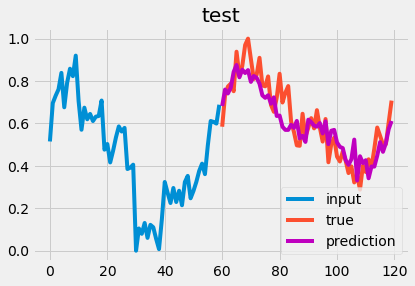

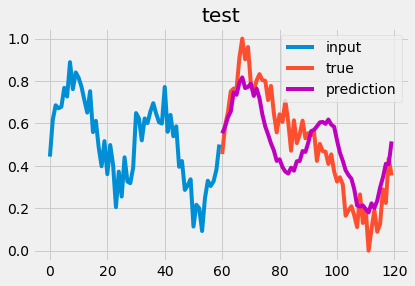

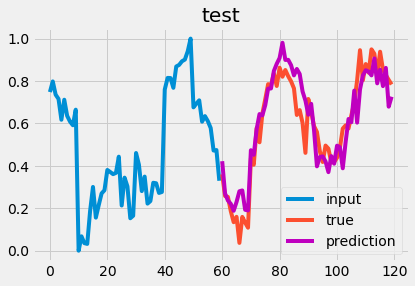

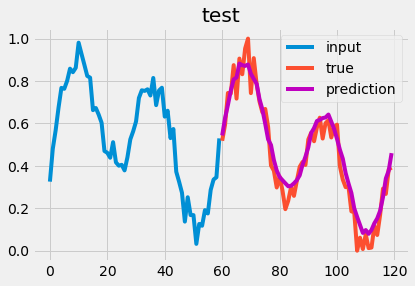

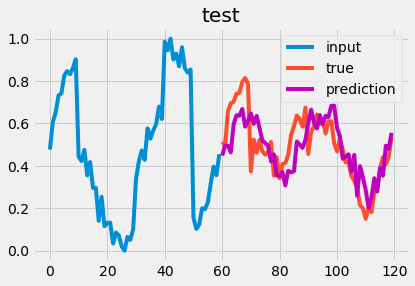

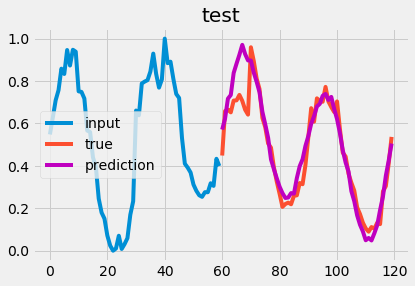

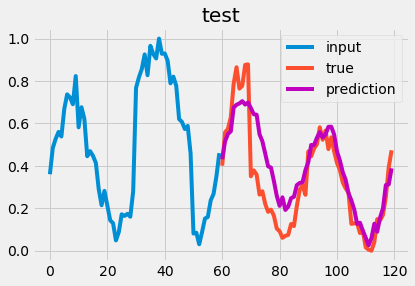

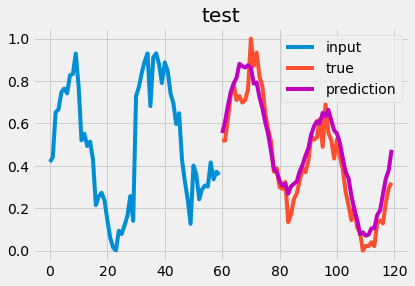

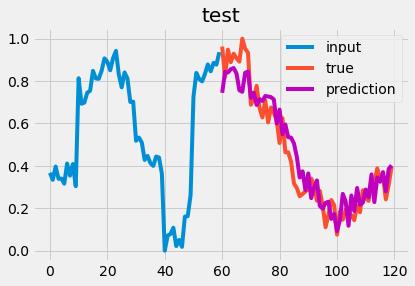

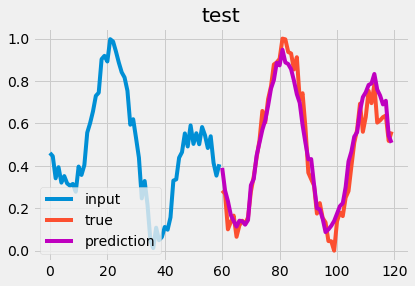

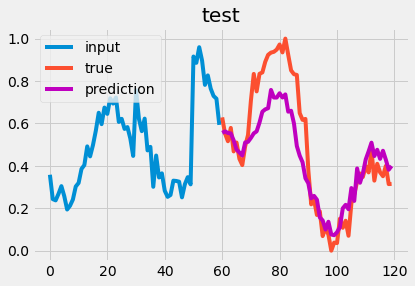

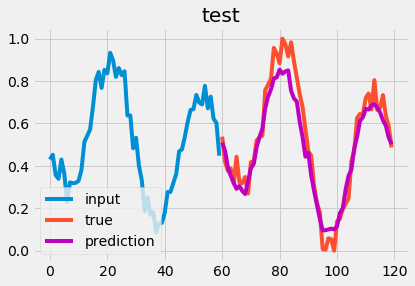

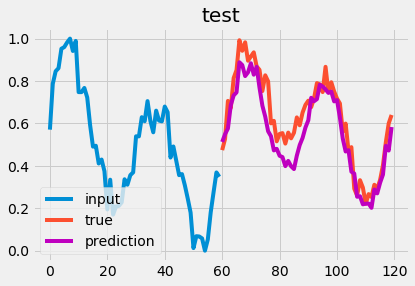

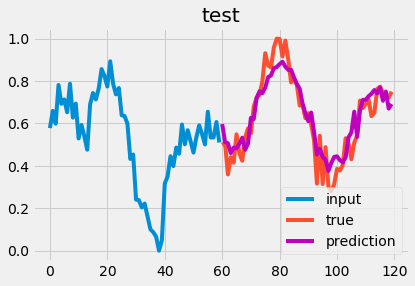

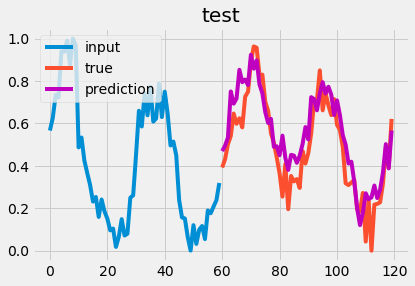

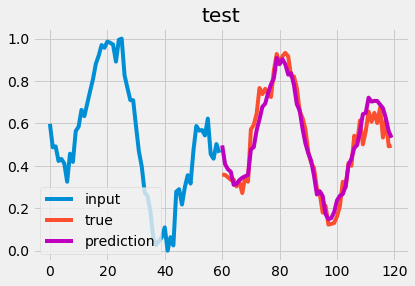

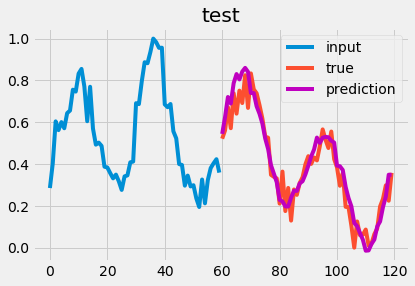

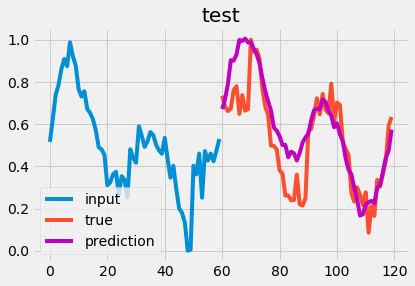

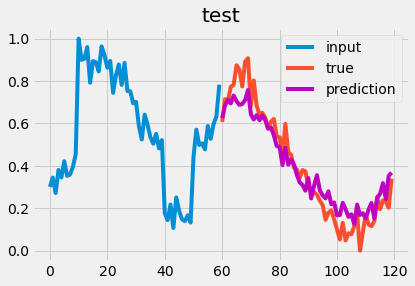

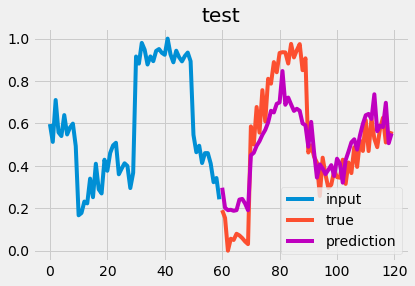

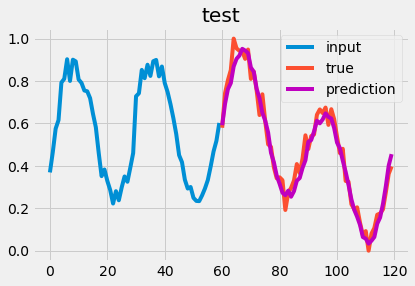

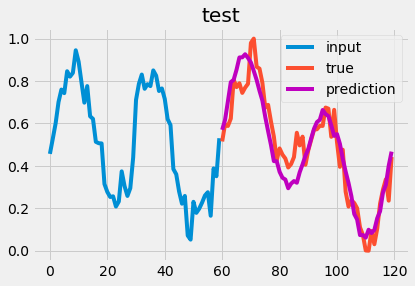

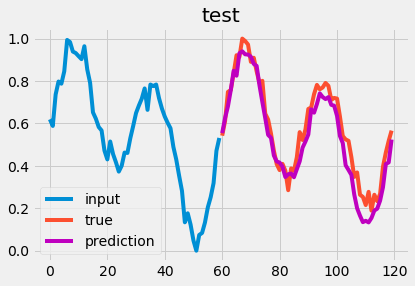

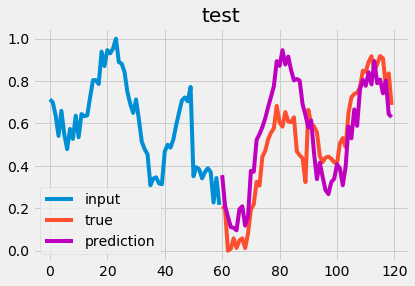

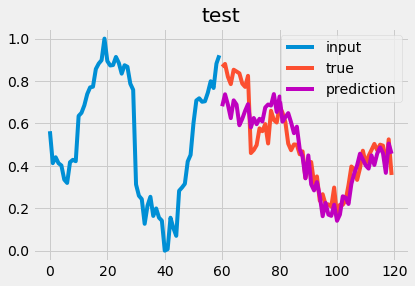

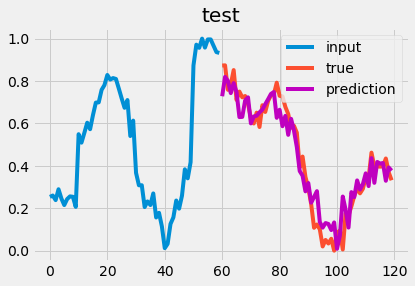

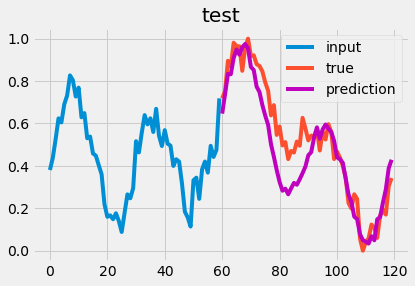

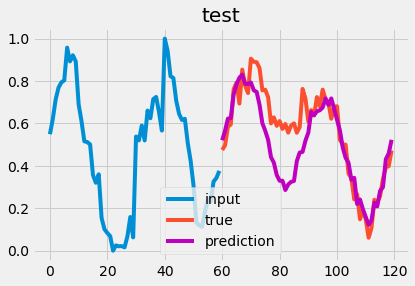

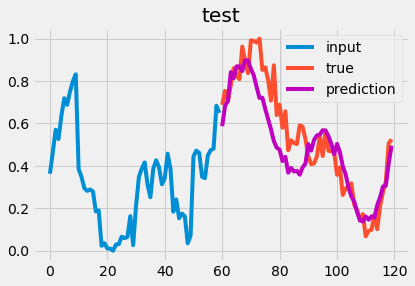

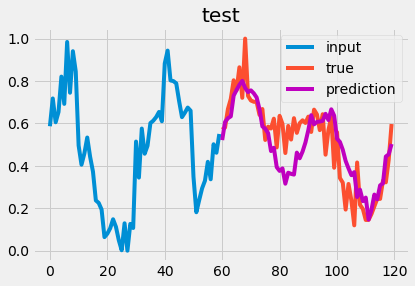

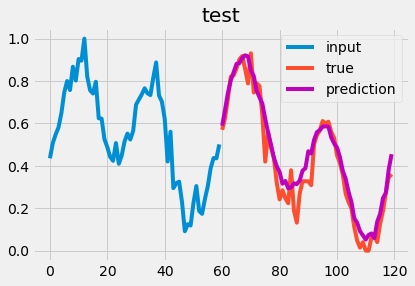

In [92]:
y_pred_test = model.predict(x_test)

random_indexes = range(data_numpy.shape[0]/2)
random.shuffle(random_indexes)

for i in random_indexes[:40]:
    plt.figure()
    plt.plot(range(60), x_test[i], label='input')
    plt.plot(range(60, 120), y_test[i], label='true')
    plt.plot(range(60, 120), y_pred_test[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

# Trading

In [106]:
y_pred_test = model.predict(x_test) / 2000

cost_function = []
for n in np.linspace(0, 1, 20):
    trade = np.zeros((data.shape[1], 2), dtype=float)
    for i in range(num_of_ts/2):
        std = np.std(y_pred_test[i, :])
        _, min_element_spread, max_element_spread = max_diff(y_pred_test[i, :])
        min_achieved = False
        for val in y_pred_test[i, :]:
            if val < min_element_spread + n * std:
                trade[i, 0] = val
                min_achieved = True
            if min_achieved and val > max_element_spread - n * std:
                trade[i, 1] = val

                break

    cost_function_n = np.sum(trade[:, 1] - trade[:, 0])
    cost_function.append(cost_function_n)
    print 'We have earned {:.3f} with gap parameter = {:.2f}'.format(cost_function_n, n)       

We have earned -0.181 with gap parameter = 0.00
We have earned 1.062 with gap parameter = 0.05
We have earned 1.048 with gap parameter = 0.11
We have earned 1.025 with gap parameter = 0.16
We have earned 0.994 with gap parameter = 0.21
We have earned 0.954 with gap parameter = 0.26
We have earned 0.909 with gap parameter = 0.32
We have earned 0.860 with gap parameter = 0.37
We have earned 0.811 with gap parameter = 0.42
We have earned 0.762 with gap parameter = 0.47
We have earned 0.717 with gap parameter = 0.53
We have earned 0.668 with gap parameter = 0.58
We have earned 0.622 with gap parameter = 0.63
We have earned 0.575 with gap parameter = 0.68
We have earned 0.522 with gap parameter = 0.74
We have earned 0.465 with gap parameter = 0.79
We have earned 0.411 with gap parameter = 0.84
We have earned 0.359 with gap parameter = 0.89
We have earned 0.323 with gap parameter = 0.95
We have earned 0.292 with gap parameter = 1.00


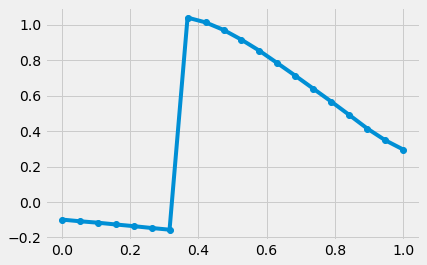

In [95]:
plt.plot(np.linspace(0, 1, 20), cost_function, marker='o');

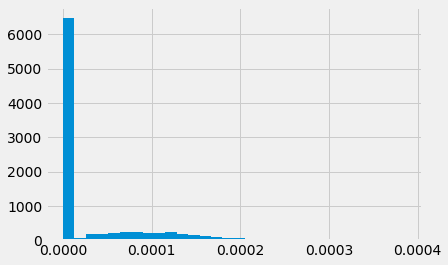

In [108]:
plt.hist(trade[:, 1] - trade[:, 0], bins=30);

### Let's calculate the Upper Bound of the revenue

First - Naive calculation

In [ ]:
naive_upper_bound = np.sum(np.max(data.values[60:, :], axis=0) - np.min(data.values[60:, :], axis=0))
print 'naive upper bound = {:.2f}'.format(naive_upper_bound)

The more realistic calculation:

(Considering, that minimum should appear before maximum)

In [ ]:
real_upper_bound = np.sum(max_diff(data.values[60:, col]) for col in range(data.values.shape[1]))
print 'real upper bound = {:.2f}'.format(real_upper_bound)

In [ ]:
np.sum(trade[:, 1] - trade[:, 0])

In [ ]:
plt.hist(trade[:, 1] - trade[:, 0], bins=30);

In [ ]:
!mv max_diff.png img/


<img src="img/max_diff.png",width=400,height=400>

# Functions
Functions for finding Minimum and Maximum in array, while minimum should be before maximum ("maximum spread").

In [8]:
def max_diff(arr):
    
    """returns max difference in list, such that
    mininmum appears before maximum"""
    
    max_diff = arr[1] - arr[0]
    min_element = arr[0]
    for val in arr:
        if val - min_element > max_diff:
            min_element_spread = min_element
            max_element_spread = val
            max_diff = val - min_element         
        if val < min_element:
            min_element = val
            
    return max_diff, min_element_spread, max_element_spread

In [ ]:
max_diff([9, 1, 2, 4, 10, -10])

In [ ]:
%%unittest_testcase

def test_max_diff(self):
    arr = [9, 1, 2, 4, 10, -10]
    res = (9, 1, 10)
#     self.assertEqual(max_diff(arr), 9)
    self.assertTupleEqual(max_diff(arr), res)